In [1]:
## BASIC QC ##

In [2]:
import community #import the 'community' module, which is often used for community detection in networks/graphs.
import networkx as nx #import the 'networkx' library, which provides tools for working with graphs and networks.
import anndata #import the 'anndata' module, which is used for handling annotated data structures.
import matplotlib #import the 'matplotlib' library for data visualization, specifically for creating plots and charts.
import matplotlib.pyplot as plt
import numpy as np #import the 'numpy' library, which is widely used for numerical operations and array manipulations.
import pandas as pd #import the 'pandas' library, which is used for data manipulation and analysis, often with tabular data.
import scanpy as sc #import the 'scanpy' library, which is commonly used for single-cell RNA sequencing data analysis.
from scanpy import tl, pl #import specific modules 'tl' (tangled lineage) and 'pl' (plotting) from the 'scanpy' library.
from sklearn.decomposition import TruncatedSVD #import 'TruncatedSVD' from the 'sklearn.decomposition' module, a dimensionality reduction technique.
from scipy import sparse, io #import 'sparse' and 'io' from the 'scipy' library, which includes various scientific computing tools.

In [3]:
#adata = sc.concat(
#    {
#        "left": sc.read_10x_mtx(‘C:\\Users\\HP\Downloads\\Kallisto_indiv\\SAMN23098192\\counts_unfiltered\\cells_x_genes.mtx’, var_names=‘gene_symbols’),
#        "right": sc.read_10x_mtx(‘C:\\Users\\HP\Downloads\\Kallisto_indiv\\SAMN23098196\\counts_unfiltered\\cells_x_genes.mtx’,var_names=‘gene_symbols’)
#    },
#    merge="unique",
#    label="condition",
#)

In [4]:
#set the verbosity level for Scanpy - in this line, the verbosity level is set to 3, which corresponds to 'hints' meaning that the code will display error messages, warnings, info, and hints while running.
sc.settings.verbosity = 3 #verbosity: errors (0), warnings (1), info (2), hints (3)

#set the figure parameters for Scanpy plots - this line configures the parameters for figures (plots) generated by Scanpy.
#here, it sets the DPI (dots per inch) for the figures to 80. DPI affects the resolution and size of the figures when they are displayed or saved.
sc.settings.set_figure_params(dpi=80)

In [5]:
#define the file path where the analysis results will be stored.
results_file = 'SAMN23098192.h5ad'

#load an unfiltered data matrix from a specified file using the 'anndata' library.
#the data is stored in the 'adata' variable.

adata = sc.concat(
    {
        "Left-sided CRC": anndata.read_h5ad("C:\\Users\\HP\Downloads\\Kallisto_indiv\\SAMN23098192\\counts_unfiltered\\adata.h5ad"),
        "Right-sided CRC": anndata.read_h5ad("C:\\Users\\HP\Downloads\\Kallisto_indiv\\SAMN23098196\\counts_unfiltered\\adata.h5ad")
    },
    merge="unique",
    label="condition",
)

#add a new column "gene_id" to the 'var' (variables) DataFrame in the 'adata' object.
#the values for this new column are taken from the index of the 'var' DataFrame.
adata.var["gene_id"] = adata.var.index.values

#read a table containing transcript-to-gene mapping information from a file.
t2g = pd.read_csv("C:\\Users\\HP\\Downloads\\Kallisto_indiv\\Reference\\t2g.txt",
                  header=None,
                  names=["tid", "gene_id", "gene_name", "gene_ver", "chr", "n1", "n2", "strand"],
                  sep="\t") #tells Pandas to split the values in the file based on tabs, which is common when dealing with tab-delimited files

#set the index of the 't2g' DataFrame to the "gene_id" column.
t2g.index = t2g.gene_id

#remove duplicate entries in the 't2g' DataFrame, keeping only the first occurrence.
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

#map gene names from the 't2g' DataFrame to the "gene_name" column in the 'var' DataFrame of 'adata'.
adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])

#set the index of the 'var' DataFrame in 'adata' to be the "gene_name" column.
adata.var.index = adata.var["gene_name"]

#ensure that the variable (gene) names in 'adata' are unique.
#this step is unnecessary if you use `var_names='gene_ids'` in the `sc.read_10x_mtx` function.
adata.var_names_make_unique()

C:\Python Software\Python3_11_3\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
#display the first few rows (by default, the first 5 rows) of the 't2g' DataFrame.
#this allows you to quickly inspect the contents of the DataFrame.
t2g.head()

,tid,gene_id,gene_name,gene_ver,chr,n1,n2,strand
gene_id,,,,,,,,
ENSG00000290825.1,ENST00000456328.2,ENSG00000290825.1,DDX11L2,DDX11L2-202,chr1,11869,14409,+
ENSG00000223972.6,ENST00000450305.2,ENSG00000223972.6,DDX11L1,DDX11L1-201,chr1,12010,13670,+
ENSG00000227232.5,ENST00000488147.1,ENSG00000227232.5,WASH7P,WASH7P-201,chr1,14404,29570,-
ENSG00000278267.1,ENST00000619216.1,ENSG00000278267.1,MIR6859-1,MIR6859-1-201,chr1,17369,17436,-
ENSG00000243485.5,ENST00000473358.1,ENSG00000243485.5,MIR1302-2HG,MIR1302-2HG-202,chr1,29554,31097,+


In [7]:
adata

AnnData object with n_obs × n_vars = 745005 × 34859
    obs: 'condition'
    var: 'gene_name', 'gene_id'

In [8]:
## TEST FOR LIBRARY SATURATION ##

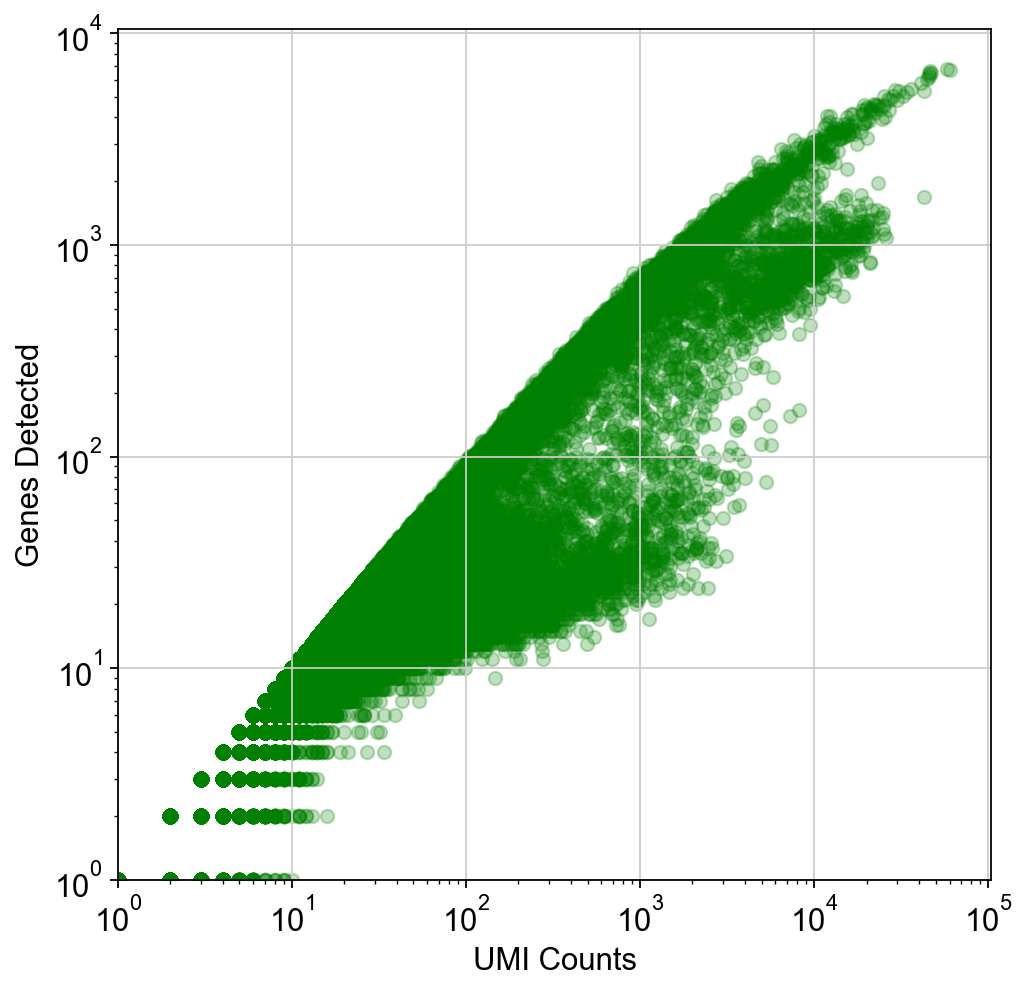

In [9]:
#create a scatter plot to visualize the relationship between UMI counts and detected genes.
#the code sets up a figure and axes for the plot, specifies the data to be plotted, and adjusts the plot settings.
fig, ax = plt.subplots(figsize=(7, 7))

#calculate the UMI counts for each cell by summing the elements along axis 1 of the 'adata.X' matrix.
x = np.asarray(adata.X.sum(axis=1))[:, 0]

#calculate the number of genes detected in each cell by counting elements greater than zero along axis 1.
y = np.asarray(np.sum(adata.X > 0, axis=1))[:, 0]

#create a scatter plot with green dots, adjusting the transparency (alpha) to 0.25 for better visualization.
ax.scatter(x, y, color="green", alpha=0.25)

#set labels for the x and y axes.
ax.set_xlabel("UMI Counts")         # X-axis label
ax.set_ylabel("Genes Detected")    # Y-axis label

#set the x and y scales to be logarithmic, which can be helpful for visualizing data with a wide range.
ax.set_xscale('log')
ax.set_yscale('log')

#set the lower bounds for the x and y axes to 1 to avoid displaying values below 1.
ax.set_xlim(1)
ax.set_ylim(1)

#display the plot.
plt.show()

#download the figure
fig.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\1.scatter_plot.png', dpi=100)

#note: plot can be misleading due to overlapping points,and it may take a minute to run because there are many data points to process.

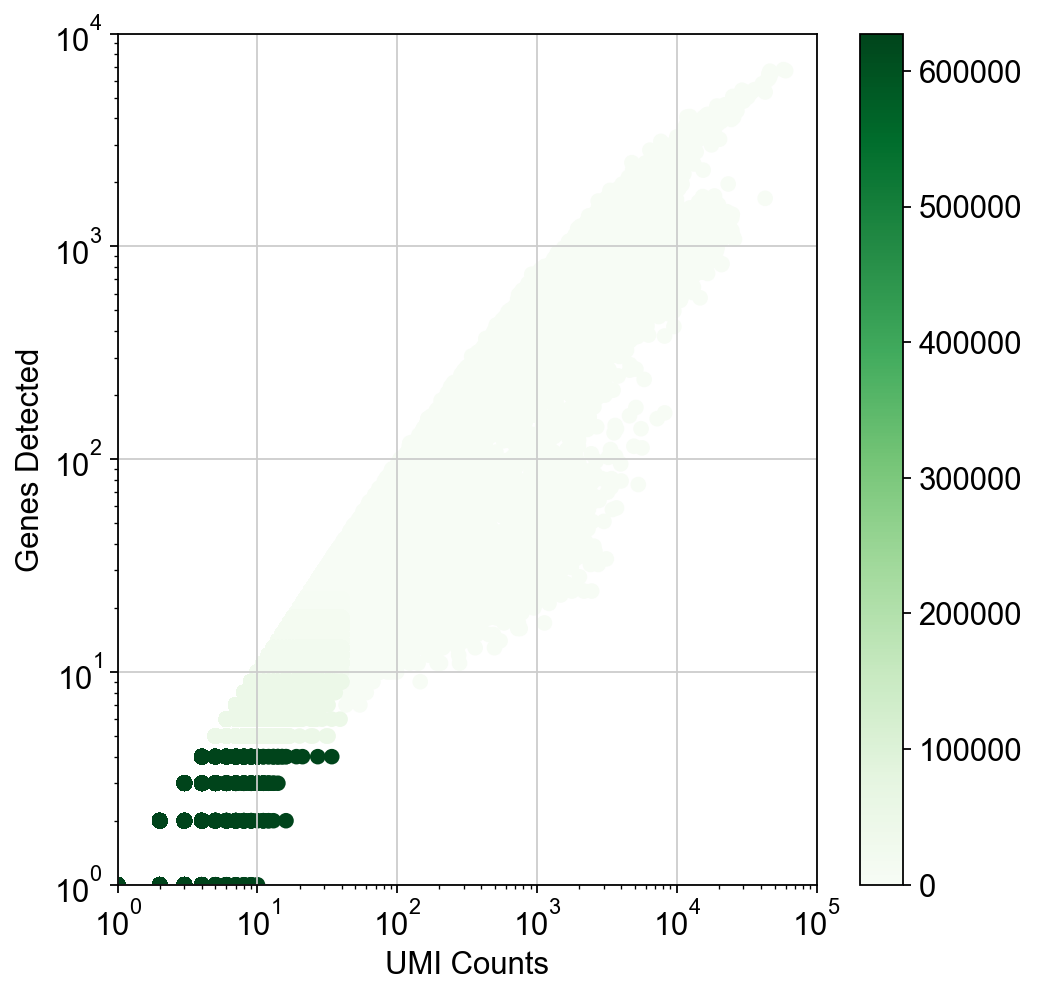

In [10]:
#create a scatter plot with a heatmap-like appearance to visualize the density of data points.
#the code sets up a figure and axes for the plot, calculates a 2D histogram, and adjusts the plot settings.

#create a figure and axes with a specific size (7x7 inches).
fig, ax = plt.subplots(figsize=(7, 7))

#define the number of bins for the 2D histogram.
bins = [1500, 1500]  # Number of bins in x and y dimensions

#calculate a 2D histogram of the data points (x, y) using the specified bins.
hh, locx, locy = np.histogram2d(x, y, bins=bins)

#sort the points by density to ensure that the densest points are plotted last.
z = np.array([hh[np.argmax(a <= locx[1:]), np.argmax(b <= locy[1:])] for a, b in zip(x, y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

#create a scatter plot with points colored based on their density values (z2) using a colormap.
s = ax.scatter(x2, y2, c=z2, cmap='Greens')

#add a colorbar to the plot to indicate the mapping of colors to density values.
fig.colorbar(s, ax=ax)

#set the x and y scales to be logarithmic, suitable for this type of visualization.
ax.set_xscale('log')
ax.set_yscale('log')

#set labels for the x and y axes.
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

#set the limits for the x and y axes, adjusting the range of values displayed.
ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

#display the plot.
plt.show()

#download the figure
fig.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\2.scatter_heatmap.png', dpi=100)

In [11]:
## EXAMINE THE KNEE PLOT ##

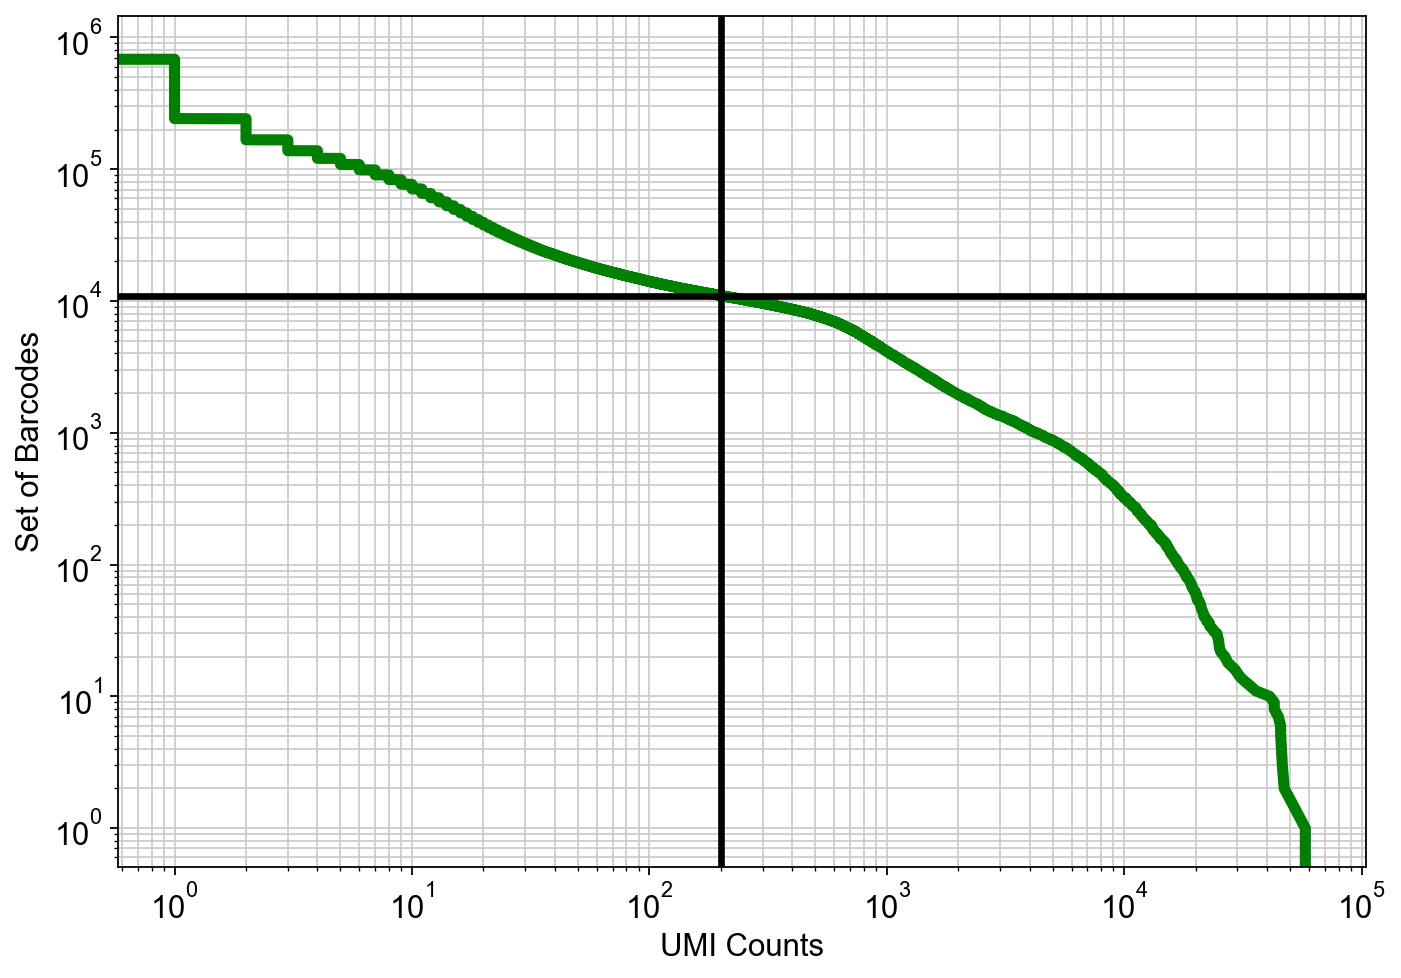

In [12]:
#the code allows users to set a threshold for UMI counts and visualize the knee plot.
#users can adjust the 'cutoff' parameter to define the threshold interactively.

#import required libraries and modules (e.g., numpy and matplotlib) have been imported earlier.

#set the initial threshold value to 200 (can be adjusted interactively).
cutoff = 200

#generate a knee plot for UMI counts to help users choose a threshold.
#the 'knee' variable contains the sorted UMI counts in descending order.
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

#create an array 'cell_set' representing the set of barcodes (cell indices).
cell_set = np.arange(len(knee))

#calculate the number of cells that have UMI counts greater than the chosen 'cutoff'.
#'num_cells' will be the number of cells retained after thresholding.
num_cells = cell_set[knee > cutoff][::-1][0]

#create a figure and axes for the knee plot with specified dimensions.
fig, ax = plt.subplots(figsize=(10, 7))

#create a log-log plot of UMI counts versus the set of barcodes.
ax.loglog(knee, cell_set, linewidth=5, color="g")

#add a vertical line at the chosen 'cutoff' to visualize the threshold.
ax.axvline(x=cutoff, linewidth=3, color="k")

#add a horizontal line at the height corresponding to the number of retained cells.
ax.axhline(y=num_cells, linewidth=3, color="k")

#set labels for the x and y axes.
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

#add gridlines to the plot for better reference.
plt.grid(True, which="both")

#display the knee plot.
plt.show()

#download the figure
fig.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\3.knee_plot.png', dpi=100)

In [13]:
## ANALYSIS ##

normalizing counts per cell
    finished (0:00:00)


C:\Python Software\Python3_11_3\Lib\site-packages\scanpy\preprocessing\_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


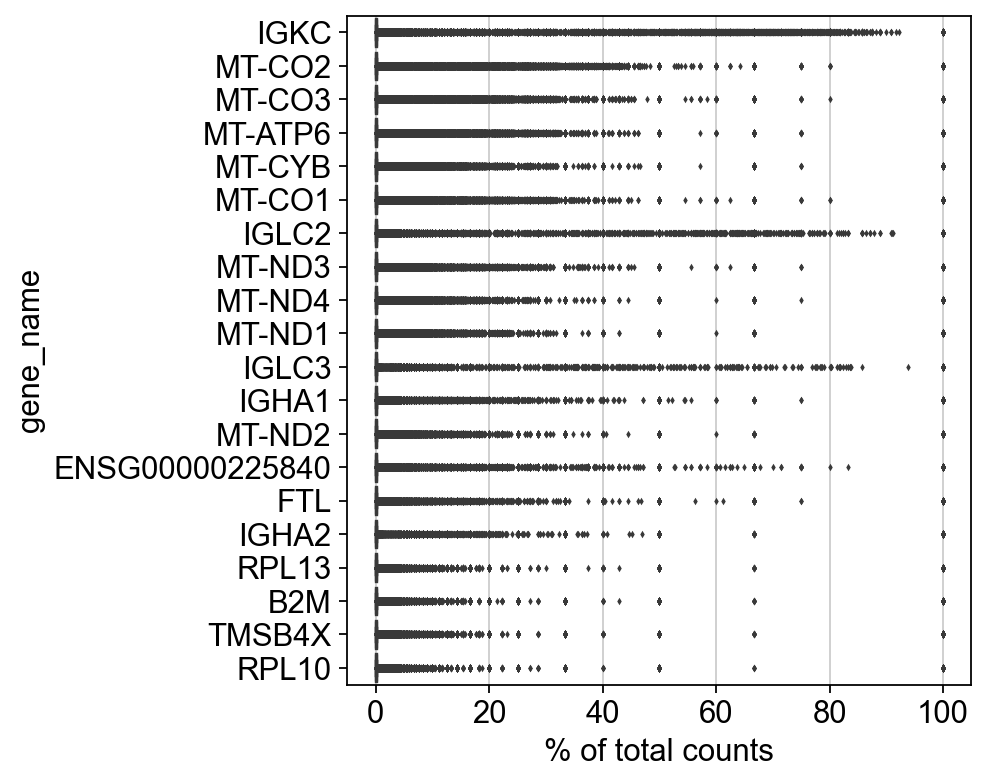

In [14]:
#generate a plot showing the highest expressed genes in the single-cell RNA sequencing (scRNA-seq) data.
#the code uses Scanpy's 'pl.highest_expr_genes' function to create this plot.

#'sc.pl.highest_expr_genes' is a function from the Scanpy library used for visualization.

#'adata' is the annotated data object that contains scRNA-seq data.

#'n_top=20' specifies that the top 20 highest expressed genes should be included in the plot.
#can adjust this parameter to visualize a different number of top genes.

#the resulting plot will typically display a bar chart or heatmap of the selected genes.
#this visualization can help identify highly expressed genes, which can be important in scRNA-seq data analysis.
sc.pl.highest_expr_genes(adata, n_top=20)

In [15]:
## FILTER ##
#begin by filtering cells according to various criteria. First, a filter for genes and cells based on minimum thresholds:

In [16]:
#removes cells with less than 1070 umi counts
adata = adata[np.asarray(adata.X.sum(axis=1)).reshape(-1) > 1070]

#removes genes with 0 umi counts
adata = adata[:, np.asarray(adata.X.sum(axis=0)).reshape(-1) > 0]

In [17]:
adata

View of AnnData object with n_obs × n_vars = 3858 × 20124
    obs: 'condition'
    var: 'gene_name', 'gene_id'

In [18]:
#perform cell and gene filtering on the 'adata' object using Scanpy's preprocessing functions.

#filter cells based on the minimum number of expressed genes.
#this line removes cells (samples) from the 'adata' object that express fewer than 200 genes.
#'sc.pp.filter_cells' is a Scanpy function for cell filtering.
#'min_genes=200' specifies the minimum number of genes a cell must express to be retained.
sc.pp.filter_cells(adata, min_genes=200)

#filter genes based on the minimum number of cells expressing them.
#this line removes genes (features) from the 'adata' object that are expressed in fewer than 3 cells.

#'sc.pp.filter_genes' is a Scanpy function for gene filtering.
#'min_cells=3' specifies the minimum number of cells in which a gene must be expressed to be retained.
sc.pp.filter_genes(adata, min_cells=3)

filtered out 299 cells that have less than 200 genes expressed


C:\Python Software\Python3_11_3\Lib\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
C:\Python Software\Python3_11_3\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


filtered out 3082 genes that are detected in less than 3 cells


C:\Python Software\Python3_11_3\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Python Software\Python3_11_3\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [19]:
adata

AnnData object with n_obs × n_vars = 3559 × 17042
    obs: 'condition', 'n_genes'
    var: 'gene_name', 'gene_id', 'n_cells'

In [20]:
#identify mitochondrial genes in the dataset based on gene names.
#this line creates a boolean mask 'mito_genes' that checks if each gene name starts with 'MT-' (indicating mitochondrial genes).

mito_genes = adata.var_names.str.startswith('MT-')

#compute the fraction of counts in mitochondrial genes vs. all genes for each cell.
#this line calculates the percentage of UMI counts in mitochondrial genes relative to the total counts for each cell.

#the `.A1` is used to transform the result from a sparse matrix to a dense NumPy array.
#for each cell, the numerator sums the counts in mitochondrial genes (`.X` extracts the matrix), and the denominator sums the total counts across all genes.
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

#add the total UMI counts per cell as an observation annotation to 'adata'.
#this line calculates and stores the total UMI counts for each cell in the 'n_counts' column of the observation metadata.

#the `.X.sum(axis=1)` computes the total UMI counts per cell, and `.A1` converts it to a dense array.
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

C:\Python Software\Python3_11_3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


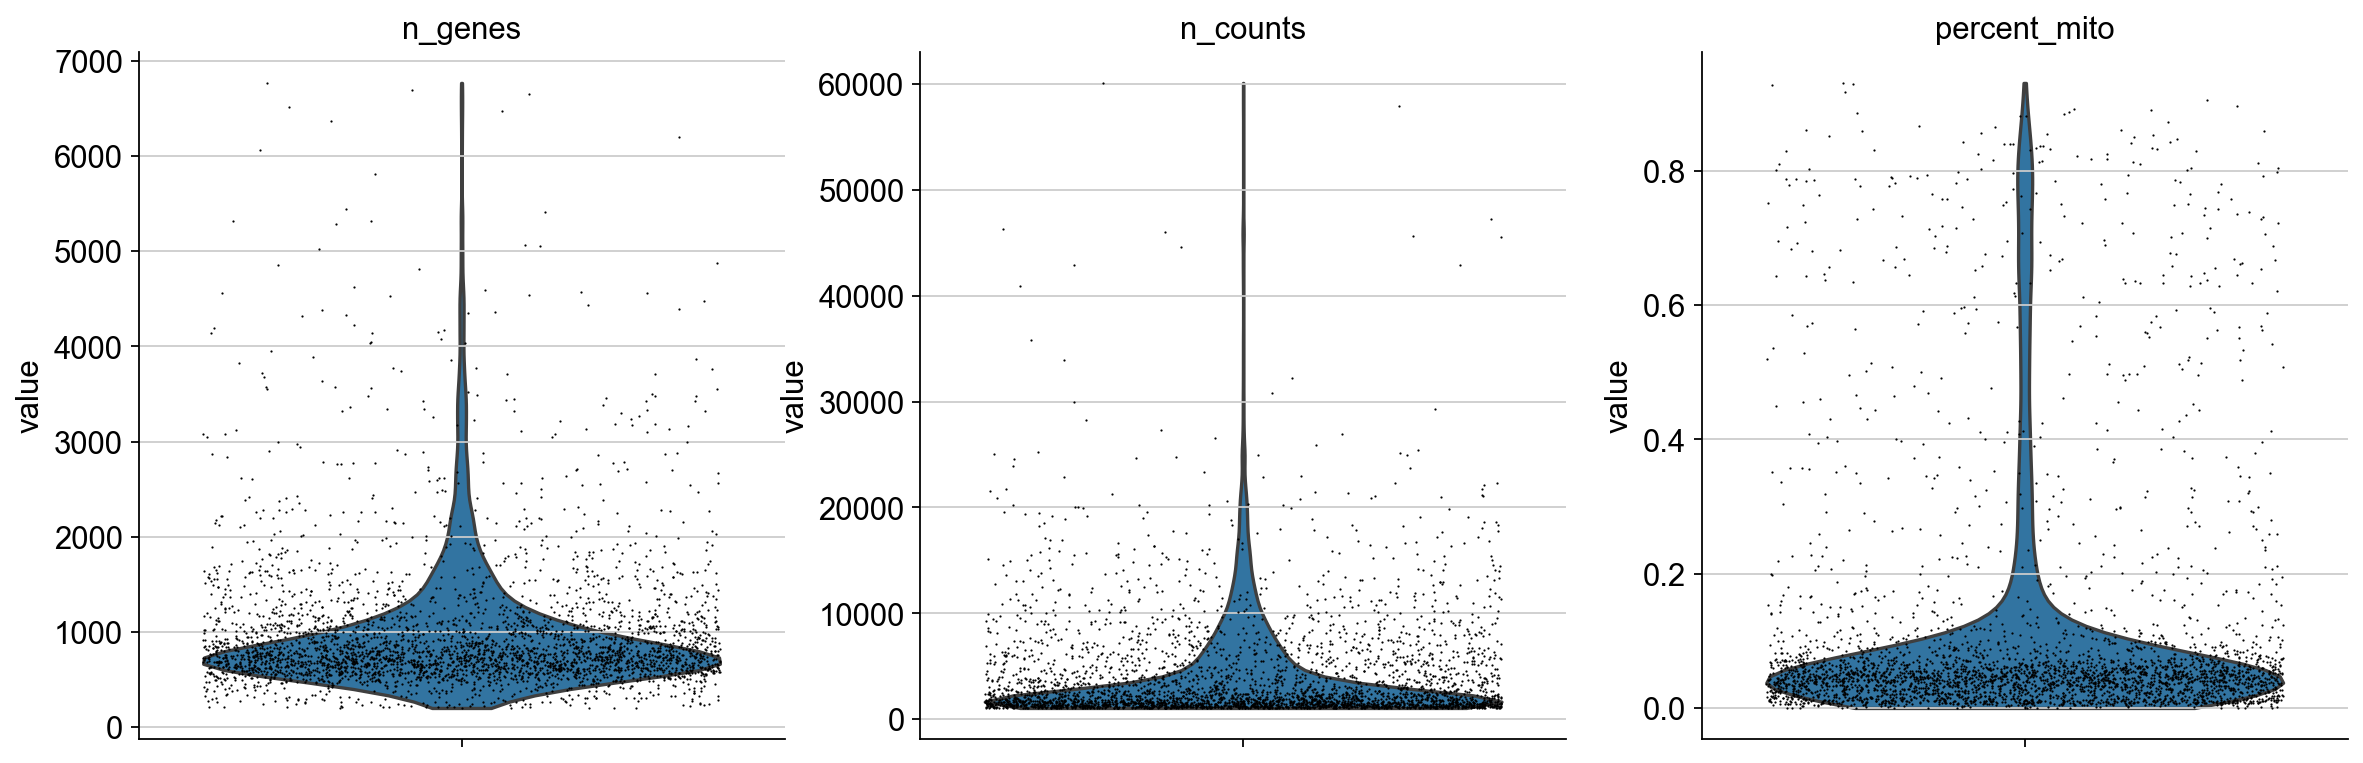

In [21]:
#generate a violin plot to visualize the distribution of several key metrics across cells.
#this code uses Scanpy's 'pl.violin' function to create the violin plot.

#'adata' is the annotated data object that contains single-cell RNA sequencing (scRNA-seq) data.

#the list ['n_genes', 'n_counts', 'percent_mito'] specifies the metrics to be visualized in the plot.
#these metrics are:
#- 'n_genes': Number of genes expressed in each cell.
#- 'n_counts': Total UMI counts per cell.
#- 'percent_mito': Percentage of UMI counts derived from mitochondrial genes.

#the 'jitter=0.4' argument adds jitter to the data points for better visualization.

#the 'multi_panel=True' argument indicates that multiple panels should be used for different metrics.
#this results in separate violin plots for each metric, allowing easy comparison between them.
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, show=False)

#download the figure
plt.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\4.violin_plot.png', bbox_inches='tight', dpi=100)

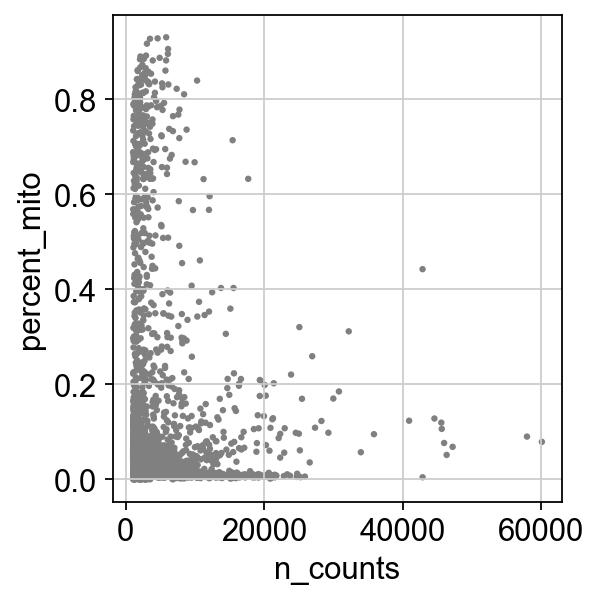

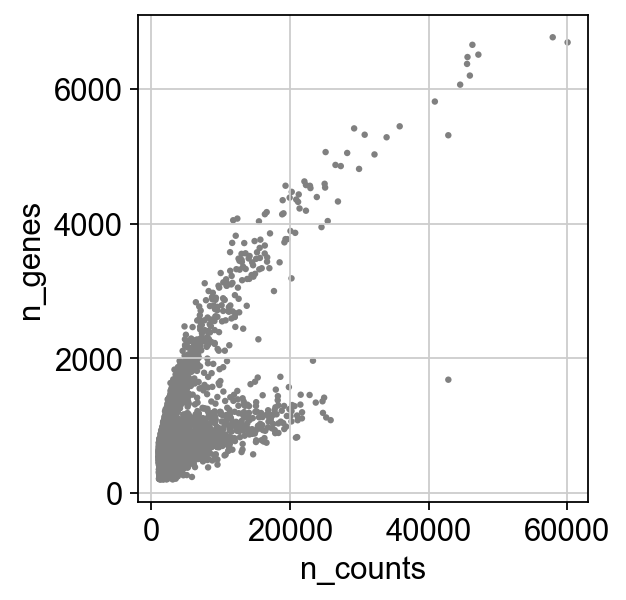

In [22]:
#examine mitochondrial content and other cell metrics using scatter plots.
#this code uses Scanpy's 'pl.scatter' function to create two scatter plots for data exploration.

#'adata' is the annotated data object containing single-cell RNA sequencing (scRNA-seq) data.

#scatter Plot 1: Examining Mitochondrial Content vs. Total UMI Counts

#- 'x='n_counts'' specifies the x-axis as 'n_counts,' representing the total UMI counts per cell.
#- 'y='percent_mito'' specifies the y-axis as 'percent_mito,' representing the percentage of UMI counts from mitochondrial genes.

#this scatter plot visualizes the relationship between mitochondrial content and total UMI counts for each cell.
sc.pl.scatter(adata, x='n_counts', y='percent_mito', show=False)
plt.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\5.mito_vs_UMI.png', bbox_inches='tight', dpi=100)

#scatter Plot 2: Examining Total UMI Counts vs. Number of Genes Expressed

#- 'x='n_counts'' specifies the x-axis as 'n_counts,' representing the total UMI counts per cell.
#- 'y='n_genes'' specifies the y-axis as 'n_genes,' representing the number of genes expressed in each cell.

#this scatter plot visualizes the relationship between total UMI counts and the number of genes expressed for each cell.
sc.pl.scatter(adata, x='n_counts', y='n_genes', show=False)
plt.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\6.UMI_vs_genes.png', bbox_inches='tight', dpi=100)

In [23]:
#create a boolean mask to filter out specific cells based on defined criteria.

#'adata' is the annotated data object that contains single-cell RNA sequencing (scRNA-seq) data.

#the mask is designed to filter cells that meet any of the following conditions:
#1. Cells with fewer than 200 expressed genes (adata.obs.n_genes < 200).
#2. Cells with more than 6500 expressed genes (adata.obs.n_genes > 6500).
#3. Cells with less than 0.2 mitochondrial UMI counts as a percentage of total UMI counts (adata.obs.percent_mito < 0.2).

#the 'np.logical_or' function combines these conditions using logical OR, meaning that a cell will be retained if it meets any one of these criteria.

mask = np.logical_or((adata.obs.n_genes < 6500).values, (adata.obs.n_genes > 200).values, (adata.obs.percent_mito < 0.2).values)

In [24]:
#apply the previously defined boolean mask to filter cells in the 'adata' object.

#'adata' is the annotated data object that contains single-cell RNA sequencing (scRNA-seq) data.

#'mask' is the boolean mask created earlier that specifies which cells to retain based on filtering criteria.

#this line of code filters the 'adata' object by retaining only the cells for which the corresponding entries in the 'mask' are 'True'.
#cells that do not meet the specified conditions in the mask will be removed from the dataset.

adata = adata[mask, :]

In [25]:
adata

View of AnnData object with n_obs × n_vars = 3559 × 17042
    obs: 'condition', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_name', 'gene_id', 'n_cells'

In [26]:
## NORMALISE COUNTS ##
#total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [27]:
#normalize the counts in each cell to have a target sum of 10,000.

#'adata' is the annotated data object that contains single-cell RNA sequencing (scRNA-seq) data.

#'sc.pp.normalize_total' is a function from Scanpy used for total-count normalization.
#total-count normalization scales the UMI counts in each cell such that they all have the same total sum,
#which is specified by the 'target_sum' parameter.

#the 'target_sum=10**4' argument sets the desired total sum for each cell to be 10,000.

sc.pp.normalize_total(adata, target_sum=10**4)

normalizing counts per cell
    finished (0:00:00)


C:\Python Software\Python3_11_3\Lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Python Software\Python3_11_3\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [28]:
## LOG THE COUNTS ##

In [29]:
#transform the raw UMI counts in the 'adata' object by taking the natural logarithm of each count plus one.

#'adata' is the annotated data object that contains single-cell RNA sequencing (scRNA-seq) data.

#'sc.pp.log1p' is a function from Scanpy used for data transformation.
#the function performs a log transformation on the data, which helps stabilize variance and makes the data more suitable for downstream analysis.

#taking the natural logarithm of each count plus one (log1p) is a common choice for this transformation to handle zero counts gracefully.

sc.pp.log1p(adata)

In [30]:
#lets now look at the highest expressed genes after filtering, normalization, and log

normalizing counts per cell
    finished (0:00:00)


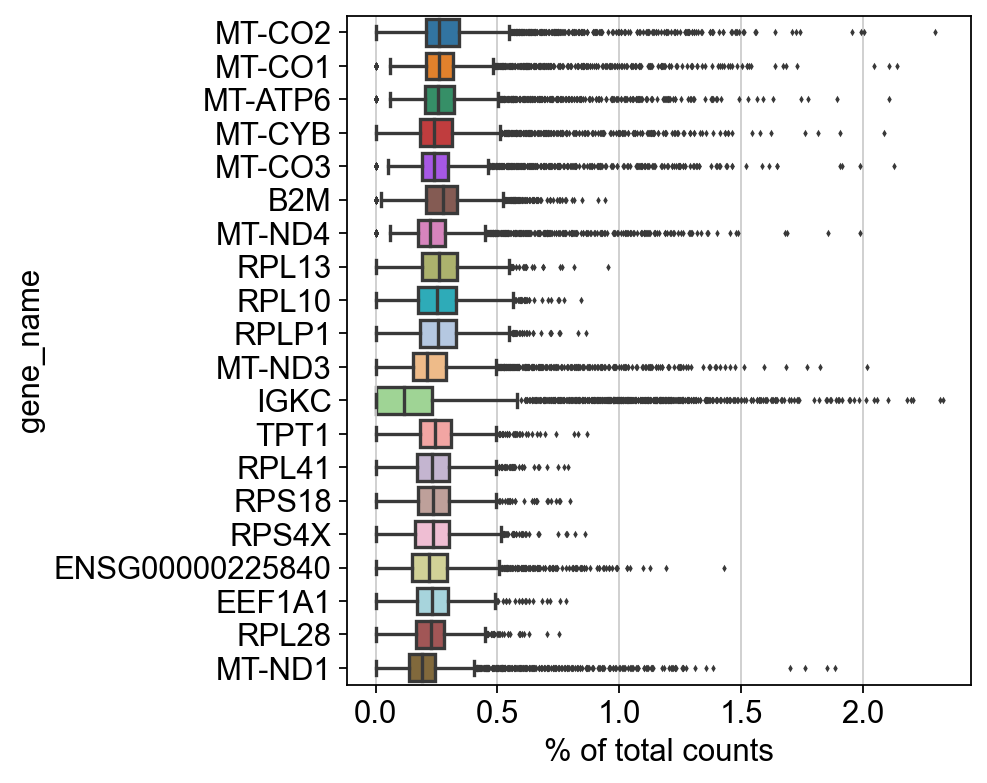

In [31]:
#create a plot showing the highest expressed genes in the single-cell RNA sequencing (scRNA-seq) dataset.

#'adata' is the annotated data object that contains the scRNA-seq data.

#'sc.pl.highest_expr_genes' is a function from Scanpy used for visualization.
#it generates a plot highlighting the top expressed genes in the dataset.

#'n_top=20' specifies that the top 20 highest expressed genes should be included in the plot.
#you can adjust this parameter to visualize a different number of top genes.

#the resulting plot typically displays a bar chart or heatmap of the selected top genes, helping identify genes with the highest expression levels.
sc.pl.highest_expr_genes(adata, n_top=20, show=False)

#download the figure
plt.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\7.highest_exp_genes_1.png', bbox_inches='tight', dpi=100)

In [32]:
adata.raw = adata

#store the normalized and logarithmized raw gene expression data as the `.raw` attribute of the AnnData object.

#'adata' is the annotated data object that contains single-cell RNA sequencing (scRNA-seq) data.

#the purpose of this code is to preserve the original, unnormalized gene expression data for future use in differential testing and gene expression visualizations.

#by assigning 'adata.raw = adata,' the `.raw` attribute of the 'adata' object is set to the same data object itself.
#this effectively "freezes" the state of the AnnData object and stores the original, unprocessed gene expression data in the `.raw` attribute.

#storing the raw data in `.raw` is useful for differential gene expression analysis and for visualizations where the unprocessed data is needed.

#the comment also notes that the result of highly variable genes detection (if performed) will be stored as an annotation in `.var.highly_variable`.
#this annotation is auto-detected by principal component analysis (PCA) and subsequently used in clustering and other analysis steps such as `sc.pp.neighbors` and manifold/graph-based tools.


In [33]:
## IDENTIFY HIGHLY-VARIABLE GENES ##

In [34]:
#detect highly variable genes in the single-cell RNA sequencing (scRNA-seq) dataset.

#'adata' is the annotated data object containing scRNA-seq data.

#'sc.pp.highly_variable_genes' is a Scanpy function used for identifying highly variable genes.
#highly variable genes are genes that exhibit significant variation in expression across cells.

#the parameters used in this function are as follows:

#- 'min_mean=0.01' specifies the minimum mean expression for a gene to be considered.
#- 'max_mean=8' specifies the maximum mean expression for a gene to be considered.
#- 'min_disp=1' specifies the minimum dispersion (variance) for a gene to be considered.
#- 'n_top_genes=2000' sets a limit on the number of highly variable genes to be detected.
#- 'flavor="cell_ranger"' specifies the method to detect highly variable genes, and it's set to be consistent with the Cell Ranger pipeline.
#- 'n_bins=20' is used to specify the number of bins for binning data in flavor="cell_ranger" method.

#the purpose of this code is to identify genes that exhibit substantial variation in expression across cells.
#highly variable genes are often used in downstream analysis steps such as dimensionality reduction and clustering.

#the choice of parameters, including 'min_mean,' 'max_mean,' and 'min_disp,' can influence the detection of highly variable genes.
#the 'flavor' parameter is used to select the method for this detection, and "cell_ranger" flavor is consistent with the Cell Ranger pipeline,
#whereas "seurat" flavor might be used for consistency with Seurat, another popular scRNA-seq analysis tool.
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=2000, flavor="cell_ranger", n_bins=20)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


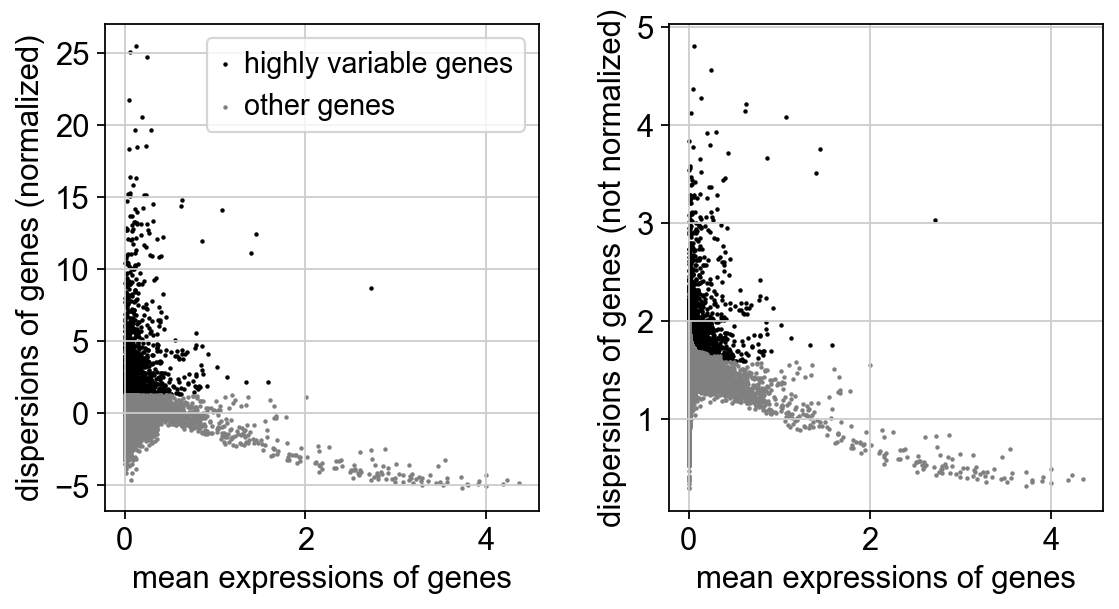

In [35]:
#generate a plot to visualize highly variable genes in the single-cell RNA sequencing (scRNA-seq) dataset.

#'adata' is the annotated data object containing scRNA-seq data.

#'sc.pl.highly_variable_genes' is a function from Scanpy used to create this visualization.
#it generates a plot that typically displays the expression levels and other characteristics of highly variable genes identified in the dataset.

#the purpose of this code is to visualize the genes that have been previously identified as highly variable in the dataset.
#highly variable genes are genes that exhibit significant variation in expression across cells.

#additionally, the code contains a comment that describes two common preprocessing steps that are often applied to scRNA-seq data, but they are not applied here:
#1. Regressing out effects of total counts per cell: This step is used to remove the influence of total UMI counts per cell on gene expression.
#2. Regressing out the percentage of mitochondrial genes expressed: This step is used to correct for the influence of mitochondrial gene expression, often linked to cell quality.

#however, the comment notes that these regression steps are not applied in this specific analysis, possibly due to a discussion or issue mentioned in the provided link.
#it's important to note that whether or not to perform these steps depends on the specific analysis goals and dataset characteristics.
sc.pl.highly_variable_genes(adata, show=False)

#download the figure
plt.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\8.highest_exp_genes_2.png', bbox_inches='tight', dpi=100)

In [36]:
## SCALING THE DATA ##

In [37]:
#scale the gene expression data in the single-cell RNA sequencing (scRNA-seq) dataset.

#'adata' is the annotated data object that contains scRNA-seq data.

#'sc.pp.scale' is a Scanpy function used for data scaling.
#the purpose of this code is to scale each gene's expression values to have unit variance, effectively normalizing the data.

#the 'max_value=10' parameter is used to clip (limit) the scaled values that exceed a standard deviation of 10.
#this is done to prevent extreme or outlier values from excessively affecting the scaling process.

#scaling the data to unit variance is a common preprocessing step in scRNA-seq analysis.
#it ensures that genes with different expression ranges contribute more equally to downstream analysis methods.
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [38]:
## PRINCIPLE COMPONENT ANALYSIS ##

In [39]:
#reduce the dimensionality of the single-cell RNA sequencing (scRNA-seq) data by performing Principal Component Analysis (PCA).

#'adata' is the annotated data object that contains scRNA-seq data.

#PCA is a dimensionality reduction technique that helps reveal the main axes of variation in the data and reduces its complexity.
#it is also used for denoising the data, which can improve the signal-to-noise ratio.

#in this code:
#- 'sc.tl.pca' is a Scanpy function used to perform PCA.
#- 'svd_solver='arpack'' specifies the Singular Value Decomposition (SVD) solver method to use.
#- 'use_highly_variable=True' indicates that PCA should be performed only on highly variable genes previously identified.
#- 'n_comps=10' specifies the number of principal components to compute; in this case, it computes the top 10 components.

#PCA is a critical step in dimensionality reduction for scRNA-seq data as it helps in capturing the most informative features and simplifying downstream analyses.
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)

computing PCA
    on highly variable genes
    with n_comps=10
    finished (0:00:01)


C:\Python Software\Python3_11_3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


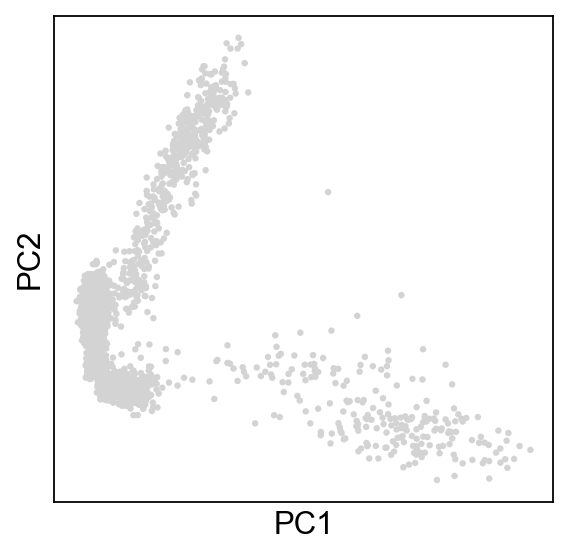

In [40]:
#create a visualization of the Principal Component Analysis (PCA) results.

#'adata' is the annotated data object that contains the single-cell RNA sequencing (scRNA-seq) data.

#'sc.pl.pca' is a function from Scanpy used for visualizing the PCA results.
#this code generates a visualization to display the PCA components and their contributions to the variance in the data.

#the PCA plot typically shows cells projected onto the top principal components.
#each point in the plot represents a cell, and the position of the points reflects their position in the reduced PCA space.

#this visualization is useful for exploring the data's structure, identifying clusters of cells, and visualizing the relationships between cells based on their expression profiles.

#the PCA plot may help reveal patterns and groupings in the data, which can be essential for understanding cellular heterogeneity and other biological insights.
sc.pl.pca(adata, show=False)

#download the figure
plt.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\9.PCA.png', bbox_inches='tight', dpi=100)

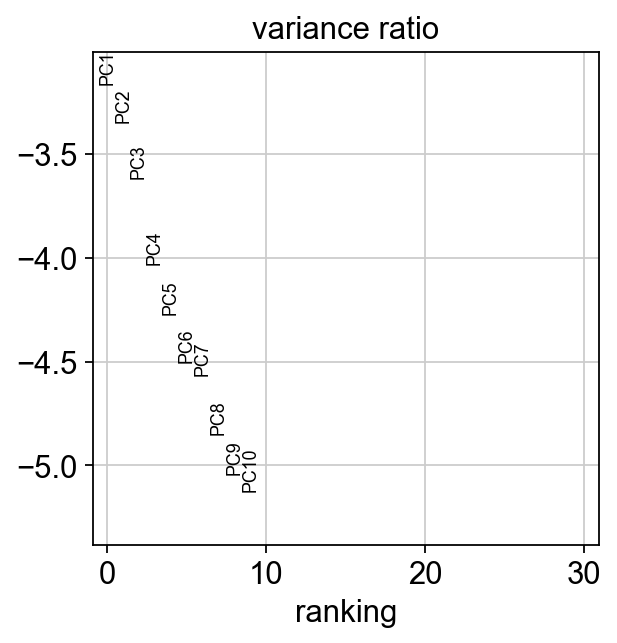

In [41]:
#visualize the variance explained by individual Principal Components (PCs) after PCA.

#'adata' is the annotated data object that contains the single-cell RNA sequencing (scRNA-seq) data.

#'sc.pl.pca_variance_ratio' is a Scanpy function used to create this visualization.
#the 'log=True' argument is specified to visualize the results on a logarithmic scale.

#this plot shows the contribution of each individual PC to the total variance in the data.
#each bar in the plot represents a PC, and its height indicates the proportion of variance explained by that PC.

#understanding the variance explained by individual PCs is crucial for determining how many PCs to consider for various downstream analyses.
#for example, it informs the selection of the number of PCs to be used in clustering (e.g., sc.tl.leiden()) or dimensionality reduction techniques like t-SNE (e.g., sc.tl.tsne()).

#a rough estimate of the number of PCs that capture a significant portion of the variance is often sufficient for many analytical tasks.
sc.pl.pca_variance_ratio(adata, log=True, show=False)

#download the figure
plt.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\10.PC_plot.png', bbox_inches='tight', dpi=100)

In [42]:
adata

AnnData object with n_obs × n_vars = 3559 × 17042
    obs: 'condition', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_name', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [43]:
## COMPUTE THE NEIGHBOURHOOD GRAPH ##

In [44]:
#next we compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. In order to be consistent with Seurat's results, we use the following values.

In [45]:
#compute the neighborhood relations of cells using the 'sc.pp.neighbors' function.

#'adata' is the annotated data object that contains the single-cell RNA sequencing (scRNA-seq) data.

#'sc.pp.neighbors' is a function from Scanpy used to compute neighborhood relations among cells.
#these neighborhood relations are typically used for downstream analysis methods like clustering and visualization.

#the parameters used in this function are:
#- 'n_neighbors=20': It specifies the number of neighbors to consider for each cell when building the neighborhood graph.
#- 'n_pcs=10': It specifies the number of Principal Components (PCs) to use for calculating distances between cells.
#  The PCs capture the most significant variation in the data, and the top 'n_pcs' are used for this analysis.

#computing neighborhood relations helps identify the similarity between cells based on their expression profiles.
#it is a crucial step for clustering cells into groups and for visualizing the data in a lower-dimensional space, such as t-SNE.

#the choice of 'n_neighbors' can influence the granularity of clusters, and 'n_pcs' determines the dimensionality used in distance calculations.
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10


C:\Python Software\Python3_11_3\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Python Software\Python3_11_3\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Python Software\Python3_11_3\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning:

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:25)


In [46]:
## EMBED THE NEIGHBOURHOOD GRAPH ##

In [47]:
## UMAP ##

In [48]:
tl.louvain(adata)

#perform graph-based analysis and dimensionality reduction for single-cell RNA sequencing (scRNA-seq) data.
#'adata' is the annotated data object containing scRNA-seq data

tl.paga(adata)
#'tl.paga' is a function from Scanpy used to perform Partition-based Graph Abstraction (PAGA).
# PAGA is a graph-based analysis method that helps reveal the connectivity and hierarchy among clusters of cells.
# this step computes the PAGA graph, which is a coarse-grained representation of the data's graph structure.

pl.paga(adata, plot=False)  #remove `plot=False` if you want to see the coarse-grained graph
#'pl.paga' is a function for visualizing the PAGA results.
#'plot=False' specifies that the PAGA graph should not be plotted in this step (remove 'plot=False' to display the graph).
# the PAGA graph visualizes the relationships and flow of information between different clusters or cell types.

tl.umap(adata, init_pos='paga')
#'tl.umap' is a function for computing a Uniform Manifold Approximation and Projection (UMAP).
# UMAP is a dimensionality reduction technique often used to visualize high-dimensional data in a lower-dimensional space.
#'init_pos='paga'' initializes the UMAP layout using information from the PAGA graph, providing an informed starting point.

#these steps help analyze and visualize the relationships and structure within the scRNA-seq data, facilitating the identification of cell clusters and their hierarchical organization.

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


In [49]:
#perform Uniform Manifold Approximation and Projection (UMAP) for dimensionality reduction and visualization of single-cell RNA sequencing (scRNA-seq) data.

#'adata' is the annotated data object containing the scRNA-seq data.

#'sc.tl.umap' is a function from Scanpy used to compute UMAP.
#UMAP is a dimensionality reduction technique that projects high-dimensional data into a lower-dimensional space while preserving local data relationships.

#in this code, UMAP is applied to the 'adata' object without any specific initialization method.
#the function will calculate the UMAP coordinates based on the original data's characteristics.

#UMAP is commonly used for visualizing scRNA-seq data, allowing researchers to explore the data's structure, identify cell clusters, and observe relationships between cells in a two-dimensional space.

#the resulting UMAP coordinates can be accessed through the 'adata.obsm['X_umap']' attribute for further visualization and analysis.
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)


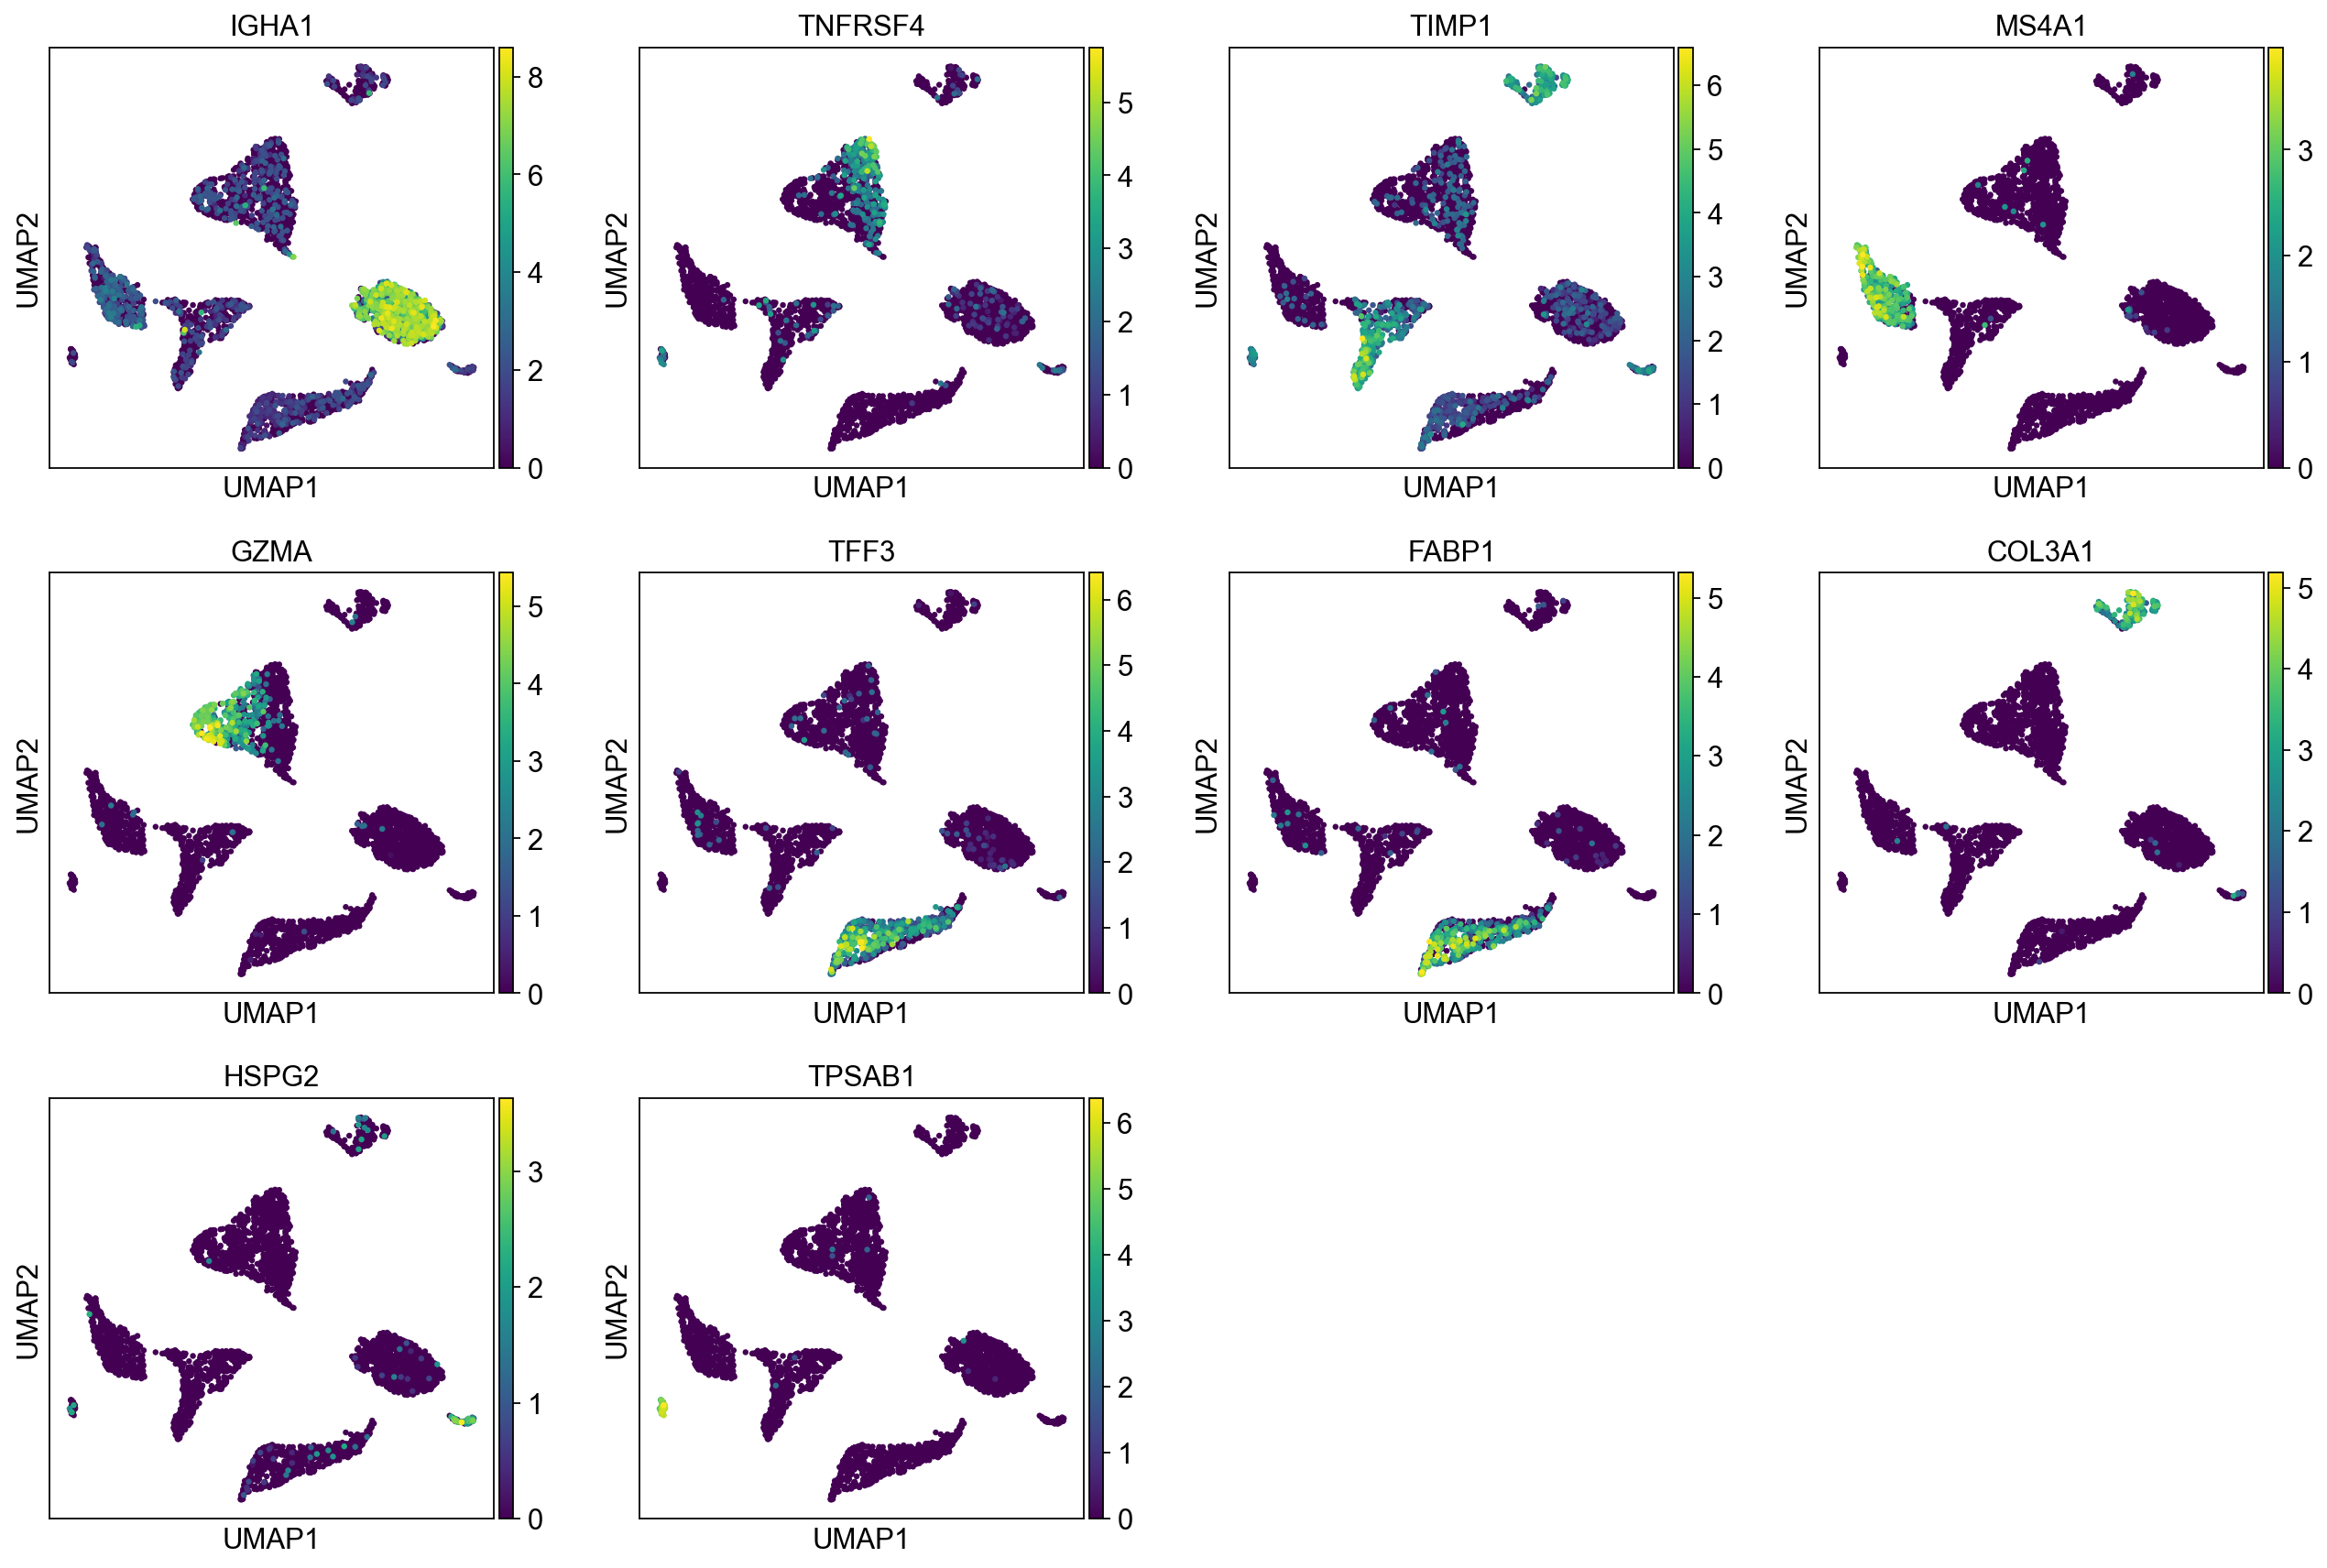

In [50]:
#create a UMAP visualization with gene expression color-coding for specific genes.

#'adata' is the annotated data object containing single-cell RNA sequencing (scRNA-seq) data.

#'sc.pl.umap' is a function from Scanpy used to generate a UMAP plot.

#the 'color' parameter is used to specify a list of genes (in this case, 'BRAF', 'CST3', 'NKG7', 'NRAS', 'PIK3CA') to color the cells in the UMAP plot.
#this parameter assigns colors to cells based on their expression levels of these genes.

#the resulting UMAP plot will display the spatial distribution of cells in a lower-dimensional space (usually 2D) and color them according to the expression of the specified genes.
#this type of visualization helps identify patterns and correlations between cell clusters and gene expression.

#researchers often select specific genes of interest to gain insights into their expression patterns and their relationships with cell types or states.
sc.pl.umap(adata, color=['IGHA1', 'TNFRSF4', 'TIMP1', 'MS4A1', 'GZMA', 'TFF3', 'FABP1', 'COL3A1', 'HSPG2', 'TPSAB1'], show=False)

#download the figure
plt.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\11.UMAP_1.png', bbox_inches='tight', dpi=100)

In [51]:
## CLUSTER THE NEIGHBOURHOOD GRAPH ##

In [52]:
## CLUSTERING ##

#there are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks, there is no univerally agreed upon method. Here we demonstrate clustering using Louvain clustering, which is a popular method for clustering single-cell RNA-seq data.

#note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [53]:
#perform Louvain clustering on single-cell RNA sequencing (scRNA-seq) data using the Louvain algorithm.

#'adata' is the annotated data object containing the scRNA-seq data.

#'sc.tl.louvain' is a function from Scanpy used to apply the Louvain clustering algorithm.
#louvain clustering is a graph-based method commonly used for identifying distinct cell clusters within scRNA-seq data.

#the parameters used in this function are:
#- 'resolution=0.5': It controls the granularity of the clustering. Higher values lead to more fine-grained clusters, while lower values result in coarser clusters.
#- 'random_state=42': It sets a random seed for reproducibility, ensuring consistent results when the algorithm involves randomness.

#louvain clustering identifies groups of cells that share similar gene expression profiles and assigns a cluster label to each cell.
#the 'resolution' parameter allows adjusting the clustering granularity, which can be helpful for exploring different levels of cell type or state hierarchy.

#after running this code, cluster assignments can be accessed through 'adata.obs['louvain']' for downstream analysis and visualization.
sc.tl.louvain(adata, resolution=0.5, random_state=42)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


C:\Python Software\Python3_11_3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


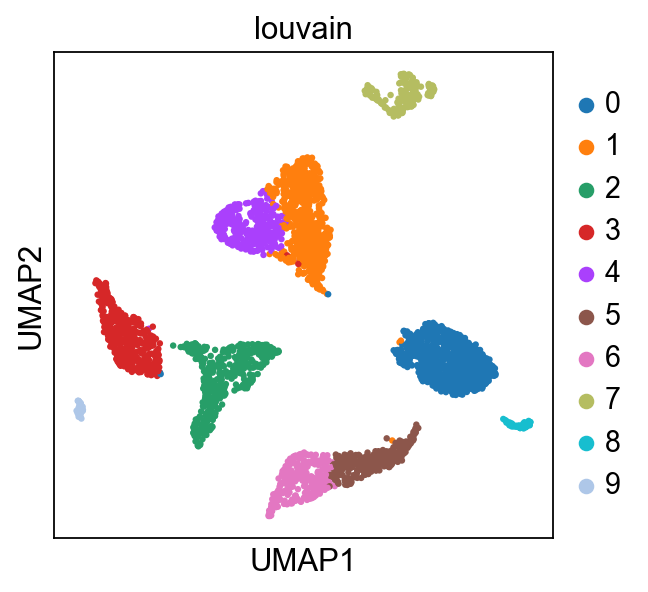

In [54]:
#create a UMAP visualization with gene expression color-coding for specific genes
sc.pl.umap(adata, color=['louvain'], show=False)

#download the figure
plt.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\12.UMAP_2.png', bbox_inches='tight', dpi=100)

C:\Python Software\Python3_11_3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


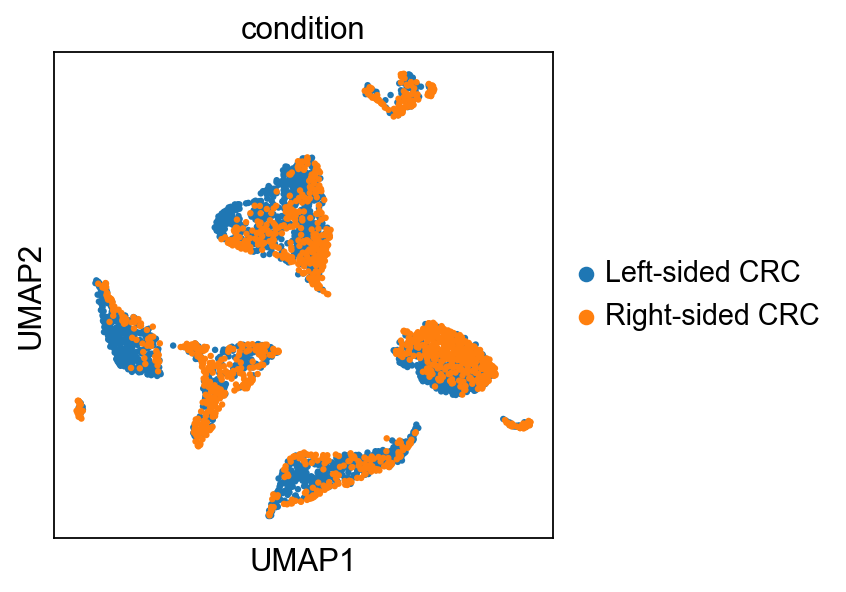

In [55]:
sc.pl.umap(adata, color='condition', show=False)
plt.savefig('C:\\Users\\HP\\Downloads\\Results\\92+96\\13.UMAP_3.png', bbox_inches='tight', dpi=100)

In [56]:
#fig, axes = plt.subplots(1,2)
#sc.pl.umap(show=False, ax=axes[0])